In [1]:
#libraries: 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from tools import time_to_seconds, clean_time_str, seconds_to_time, read_and_clean_csv

print("Current Working Directory:", os.getcwd())


Current Working Directory: /mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/yolo2/PyTorch-YOLOv3


In [2]:

# Read and clean CSV files
df1 = read_and_clean_csv("csv/train_iou_thres.csv")
df2 = read_and_clean_csv("csv/train_nms_thres.csv")
df3 = read_and_clean_csv("csv/train_conf_thres.csv")

# Combine data
df = pd.concat([df1, df2, df3])

# Calculate mean and variance by GPU
grouped_df = df.groupby('gpu').agg({
    'training_time_seconds': 'mean',
    'ev_time_seconds': 'mean',
    'sens': 'var',
    'over_detecion_rate': 'var',
    'no_hit_point_rate': 'var'
}).reset_index()

# Convert mean times back to original format
grouped_df['mean_training_time'] = grouped_df['training_time_seconds'].apply(seconds_to_time)
grouped_df['mean_ev_time'] = grouped_df['ev_time_seconds'].apply(seconds_to_time)

print("Average training and evaluation time per GPU:")
print(grouped_df[['gpu', 'mean_training_time', 'mean_ev_time', 'sens', 'over_detecion_rate', 'no_hit_point_rate']])

Average training and evaluation time per GPU:
                            gpu mean_training_time     mean_ev_time      sens  \
0  Intel(R) Iris(R) Xe Graphics    0d/1h/53m/57.0s  0d/0h/0m/11.57s  0.000000   
1    NVIDIA GeForce GTX 1080 Ti   0d/0h/36m/30.87s   0d/0h/0m/3.13s  0.016100   
2          NVIDIA GeForce MX450    0d/5h/4m/12.52s  0d/0h/0m/17.76s  0.000895   

   over_detecion_rate  no_hit_point_rate  
0            0.000000           0.000000  
1            0.000028           0.007102  
2            0.000008           0.000507  


the average of Over Detection Rate is:  0.0161
51 51 51 51


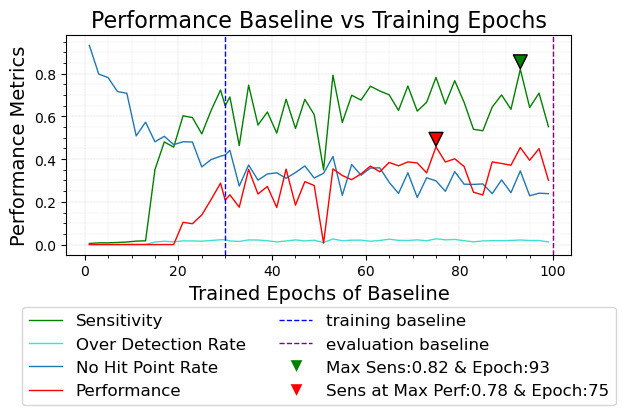

In [14]:

#baseline:
csv_file_path= "csv/baseline_ckpts.csv" 

#read the csv file:
df = pd.read_csv(csv_file_path) #df.head() #show the first 5 rows of the csv file.

train_epochs=df["train_epochs"].astype(int)
sens=df["sens"].astype(float)
o_d_r=df["over_detecion_rate"].astype(float)
n_hp_r=df["no_hit_point_rate"].astype(float)
diff_sens_fp = sens - o_d_r - n_hp_r
diff_sens_fp = diff_sens_fp.apply(lambda x: x if x >= 0 else 0) # for having a better overview: negative differences are set to 0

print("the average of Over Detection Rate is: ", round(o_d_r.mean(), 4))

#max arrows
# max sens
max_sens = sens.max()
max_sens_index = sens.idxmax()
max_sens_train_epoch = train_epochs.iloc[max_sens_index]

# max diff 
max_diff_sens_fp = diff_sens_fp.max()
max_diff_index = diff_sens_fp.idxmax()
max_diff_train_epoch = train_epochs.iloc[max_diff_index]
sens_at_max_diff = sens.iloc[max_diff_index]

print(len(train_epochs), len(sens), len(o_d_r), len(n_hp_r))

plt.plot(train_epochs, sens, linestyle='-', color='g', label='Sensitivity', linewidth=1)
plt.plot(train_epochs, o_d_r, color=(0.25, 0.88, 0.82, 1.0), label='Over Detection Rate', linewidth=1)
plt.plot(train_epochs, n_hp_r, label='No Hit Point Rate', linewidth=1)
plt.plot(train_epochs, diff_sens_fp, linestyle='-', color='r', label='Performance', linewidth=1)

baseline_line = plt.axvline(x=30, color='b', linestyle='--', linewidth=1, label='training baseline')
baseline_evaluation = plt.axvline(x=100, color='purple', linestyle='--', linewidth=1, label='evaluation baseline')
annotation = plt.annotate(f'', 
                          xy=(max_sens_train_epoch, max_sens), 
                          xytext=(max_sens_train_epoch, max_sens + 0.05),
                          arrowprops=dict(facecolor='green', shrink=0.05, headwidth=10, headlength=10, width=2),
                          ha='center', fontsize=10)
annotation_diff = plt.annotate(f'', 
                               xy=(max_diff_train_epoch, max_diff_sens_fp), 
                               xytext=(max_diff_train_epoch, max_diff_sens_fp + 0.05),
                               arrowprops=dict(facecolor='red', shrink=0.05, headwidth=10, headlength=10, width=2),
                               ha='center', fontsize=10)

dummy_point_diff = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label=f'Sens at Max Perf:{sens_at_max_diff:.2f} & Epoch:{max_diff_train_epoch}')
dummy_point = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='green', markersize=10, label=f'Max Sens:{max_sens:.2f} & Epoch:{max_sens_train_epoch}')
# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.minorticks_on()  # Enable minor ticks
plt.grid(True, which='minor', linestyle=':', linewidth=0.2)  # Add minor grid lines

# Add labels and title
plt.xlabel('Trained Epochs of Baseline', fontsize=14)
plt.ylabel('Performance Metrics', fontsize=14)
plt.title('Performance Baseline vs Training Epochs', fontsize=16)

# Add a legend with a better placement
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(dummy_point)
handles.append(dummy_point_diff)
plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=12, ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/graphen/baseline_ckpts.png', dpi=400, bbox_inches='tight')#../../
plt.show()


the average of Over Detection Rate is:  0.0211
Amount of points made:  22


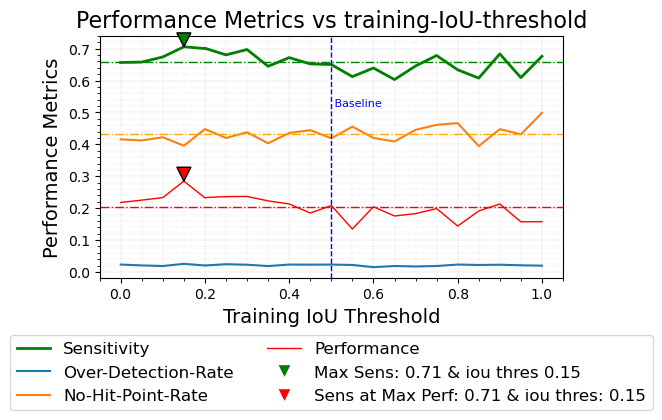

In [ ]:
# Training: IoU Threshold
csv_file_path= "csv/train_iou_thres.csv" 

#read the csv file:
df = pd.read_csv(csv_file_path)
# df = df.sort_values(by='gpu')
df = df[df['gpu'] == 'NVIDIA GeForce MX450'] # this line is needed since training on cpu produces always the same results. 
df = df.sort_values(by='train_iou_thres', ascending=True)

sens=df["sens"].astype(float)
train_iou_thres=df["train_iou_thres"].astype(float)
o_d_r=df["over_detecion_rate"].astype(float)
n_hp_r=df["no_hit_point_rate"].astype(float)
diff_sens_fp = sens - o_d_r - n_hp_r
diff_sens_fp = diff_sens_fp.apply(lambda x: x if x >= 0 else 0)  # for having a better overview: negative differences are set to 0

print("the average of Over Detection Rate is: ", round(o_d_r.mean(), 4))
print("Amount of points made: ", len(train_iou_thres))

# max sens
max_sens = sens.max()
max_sens_index = sens.idxmax()
max_sens_x= train_iou_thres[max_sens_index]

# max diff 
max_diff_sens_fp = diff_sens_fp.max() #correct 
max_diff_index = diff_sens_fp.idxmax() 
max_diff_x = train_iou_thres[max_diff_index]
sens_at_max_diff = sens[max_diff_index]

# different Gpus 
# Get the unique GPUs
# unique_gpus = df_sorted['gpu'].unique()
# print("Unique GPUs:", unique_gpus)

# Calculate the average sensitivity for each GPU
# average_sens = {}
# for gpu in unique_gpus:
#     average_sens[gpu] = df_sorted[df_sorted['gpu'] == gpu]['sens'].mean()

# colors = ['r', 'm']  # Red and pink
# avg_lines = []
# for i, (gpu, avg_sens) in enumerate(average_sens.items()):
#     line = plt.axhline(y=avg_sens, color=colors[i % len(colors)], linestyle='-.', label=f'Average Sens GPU {gpu}')
#     avg_lines.append(line)

plt.plot(train_iou_thres, sens, linestyle='-', color='g', label='Sensitivity', markersize=8, linewidth=2)
plt.plot(train_iou_thres, o_d_r, label='Over-Detection-Rate' )
plt.plot(train_iou_thres, n_hp_r, label='No-Hit-Point-Rate')
plt.plot(train_iou_thres, diff_sens_fp, linestyle='-', color='r', label='Performance', linewidth=1)

# Calculate the average values
avg_diff_sens_fp = diff_sens_fp.mean()
avg_sens = sens.mean()
avg_n_hp_r = n_hp_r.mean()

# Add average lines to the plot
plt.axhline(y=avg_diff_sens_fp, color='r', linestyle='-.', linewidth=1, label='_nolegend_')
plt.axhline(y=avg_sens, color='g', linestyle='-.', linewidth=1, label='_nolegend_')
plt.axhline(y=avg_n_hp_r, color='orange', linestyle='-.', linewidth=1, label='_nolegend_')

#baseline 
baseline_line = plt.axvline(x=0.5, color='b', linestyle='--', linewidth=1, label='_nolegend_')
plt.text(0.5, plt.ylim()[1] * 0.7, ' Baseline', color='b', fontsize=8, ha='left')

# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.minorticks_on()  # Enable minor ticks
plt.grid(True, which='minor', linestyle=':', linewidth=0.2)  # Add minor grid lines

# Annotate the maximum sensitivity point
plt.annotate(f'', 
             xy=(max_sens_x, max_sens), 
             xytext=(max_sens_x, max_sens + 0.0000005),
             arrowprops=dict(facecolor='green', shrink=0.05, headwidth=10, headlength=10, width=2),
             ha='center', fontsize=10)

# Annotate the maximum Performance point
plt.annotate(f'', 
             xy=(max_diff_x, max_diff_sens_fp), 
             xytext=(max_diff_x, max_diff_sens_fp + 0.0001),
             arrowprops=dict(facecolor='red', shrink=0.05, headwidth=10, headlength=10, width=2),
             ha='center', fontsize=10)

dummy_point_diff = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label=f'Sens at Max Perf: {sens_at_max_diff:.2f} & iou thres: {round(max_diff_x, 4)}')
dummy_point = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='green', markersize=10, label=f'Max Sens: {max_sens:.2f} & iou thres {max_sens_x}')

# Add labels and title
plt.xlabel('Training IoU Threshold', fontsize=14)
plt.ylabel('Performance Metrics', fontsize=14)
plt.title('Performance Metrics vs training-IoU-threshold', fontsize=16)

# Add a legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(dummy_point)
handles.append(dummy_point_diff)
plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=12, ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('../../graphen/train_iou_thres.png',  dpi=400, bbox_inches='tight')
plt.show()
plt.close()

Used GPUs: ['NVIDIA GeForce GTX 1080 Ti' 'NVIDIA GeForce MX450']
Average Sensitivities: {'NVIDIA GeForce GTX 1080 Ti': 0.6516294187921005, 'NVIDIA GeForce MX450': 0.6503856041131105}
the average of Over Detection Rate is:  0.0227
Amount of points made:  12


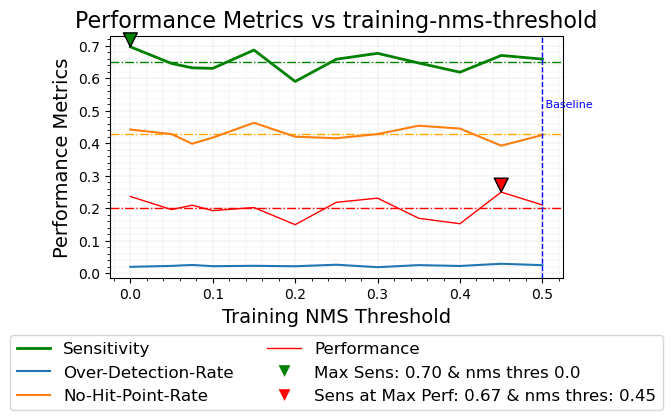

In [ ]:
# Training: Nms thres 

csv_file_path= "csv/train_nms_thres.csv" 

#read the csv file:
df = pd.read_csv(csv_file_path)
# df = df.sort_values(by='gpu')

# Filter out rows where sensitivity is 0
df = df[df['sens'] != 0]

df = df.sort_values(by='train_nms_thres', ascending=True)

# different Gpus 
unique_gpus = df['gpu'].unique()
print("Used GPUs:", unique_gpus)
average_sens = {}
for gpu in unique_gpus:
    average_sens[gpu] = df[df['gpu'] == gpu]['sens'].mean()
print("Average Sensitivities:", average_sens)

# Select only numeric columns
df_numeric = df.select_dtypes(include=[np.number])
df = df_numeric.groupby('train_nms_thres').mean().reset_index() #to average points that are crossfold validated. 


sens=df["sens"].astype(float)
train_nms_thres=df["train_nms_thres"].astype(float)
o_d_r=df["over_detecion_rate"].astype(float)
n_hp_r=df["no_hit_point_rate"].astype(float)
diff_sens_fp = sens - o_d_r - n_hp_r
diff_sens_fp = diff_sens_fp.apply(lambda x: x if x >= 0 else 0)  # for having a better overview: negative differences are set to 0

print("the average of Over Detection Rate is: ", round(o_d_r.mean(), 4))
print("Amount of points made: ", len(train_nms_thres))

# max sens
max_sens = sens.max()
max_sens_index = sens.idxmax()
max_sens_x= train_nms_thres[max_sens_index]

# max diff 
max_diff_sens_fp = diff_sens_fp.max() #correct 
max_diff_index = diff_sens_fp.idxmax() 
max_diff_x = train_nms_thres[max_diff_index]
sens_at_max_diff = sens[max_diff_index]

# Calculate the average values
avg_diff_sens_fp = diff_sens_fp.mean()
avg_sens = sens.mean()
avg_n_hp_r = n_hp_r.mean()

# Add average lines to the plot
plt.axhline(y=avg_diff_sens_fp, color='r', linestyle='-.', linewidth=1, label='_nolegend_')
plt.axhline(y=avg_sens, color='g', linestyle='-.', linewidth=1, label='_nolegend_')
plt.axhline(y=avg_n_hp_r, color='orange', linestyle='-.', linewidth=1, label='_nolegend_')

plt.plot(train_nms_thres, sens, linestyle='-', color='g', label='Sensitivity', markersize=8, linewidth=2)
plt.plot(train_nms_thres, o_d_r, label='Over-Detection-Rate' )
plt.plot(train_nms_thres, n_hp_r, label='No-Hit-Point-Rate')
plt.plot(train_nms_thres, diff_sens_fp, linestyle='-', color='r', label='Performance', linewidth=1)

# Calculate the average values
avg_diff_sens_fp = diff_sens_fp.mean()
avg_sens = sens.mean()
avg_n_hp_r = n_hp_r.mean()

#baseline 
baseline_line = plt.axvline(x=0.5, color='b', linestyle='--', linewidth=1, label='_nolegend_')
plt.text(0.5, plt.ylim()[1] * 0.7, ' Baseline', color='b', fontsize=8, ha='left')

# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.minorticks_on()  # Enable minor ticks
plt.grid(True, which='minor', linestyle=':', linewidth=0.2)  # Add minor grid lines

# Annotate the maximum sensitivity point
plt.annotate(f'', 
             xy=(max_sens_x, max_sens), 
             xytext=(max_sens_x, max_sens + 0.0000005),
             arrowprops=dict(facecolor='green', shrink=0.05, headwidth=10, headlength=10, width=2),
             ha='center', fontsize=10)

# Annotate the maximum Performance point
plt.annotate(f'', 
             xy=(max_diff_x, max_diff_sens_fp), 
             xytext=(max_diff_x, max_diff_sens_fp + 0.0001),
             arrowprops=dict(facecolor='red', shrink=0.05, headwidth=10, headlength=10, width=2),
             ha='center', fontsize=10)

dummy_point_diff = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label=f'Sens at Max Perf: {sens_at_max_diff:.2f} & nms thres: {round(max_diff_x, 4)}')
dummy_point = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='green', markersize=10, label=f'Max Sens: {max_sens:.2f} & nms thres {max_sens_x}')

# Add labels and title
plt.xlabel('Training NMS Threshold', fontsize=14)
plt.ylabel('Performance Metrics', fontsize=14)
plt.title('Performance Metrics vs training-nms-threshold', fontsize=16)

# Add a legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(dummy_point)
handles.append(dummy_point_diff)
plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=12, ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('../../graphen/train_nms_thres.png',  dpi=400, bbox_inches='tight')
plt.show()
plt.close()

Used GPUs: ['NVIDIA GeForce MX450' 'NVIDIA GeForce GTX 1080 Ti']
Average Sensitivities: {'NVIDIA GeForce MX450': 0.6610583283545265, 'NVIDIA GeForce GTX 1080 Ti': 0.6609750269059851}
the average of Over Detection Rate is:  0.022
Amount of points included:  16
Multiple occurrences: Index([], dtype='float64', name='train_conf_thres')


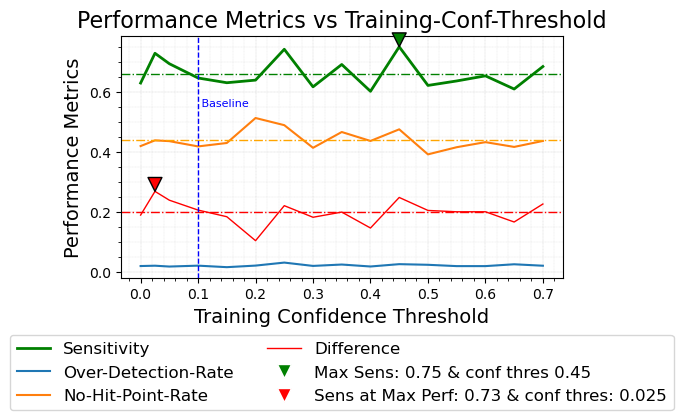

In [ ]:
# Training: Conf thres 

csv_file_path= "csv/train_conf_thres.csv" 

#read the csv file:
df = pd.read_csv(csv_file_path) 
df = df.sort_values(by='train_conf_thres', ascending=True)

# different Gpus 
unique_gpus = df['gpu'].unique()
print("Used GPUs:", unique_gpus)
average_sens = {}
for gpu in unique_gpus:
    average_sens[gpu] = df[df['gpu'] == gpu]['sens'].mean()
print("Average Sensitivities:", average_sens)

# unify cross-fold validated points
df_numeric = df.select_dtypes(include=[np.number]) # only numeric columns needs to be unified
df = df_numeric.groupby('train_conf_thres').mean().reset_index() #to average points that are crossfold validated.


sens=df["sens"].astype(float)
train_conf_thres=df["train_conf_thres"].astype(float)
o_d_r=df["over_detecion_rate"].astype(float)
n_hp_r=df["no_hit_point_rate"].astype(float)
diff_sens_fp = sens - o_d_r - n_hp_r
diff_sens_fp = diff_sens_fp.apply(lambda x: x if x >= 0 else 0)  # for having a better overview: negative differences are set to 0

print("the average of Over Detection Rate is: ", round(o_d_r.mean(), 4))
print("Amount of points included: ", len(train_conf_thres))

# max sens
max_sens = sens.max()
max_sens_index = sens.idxmax()
max_sens_x= train_conf_thres[max_sens_index]

# max diff 
max_diff_sens_fp = diff_sens_fp.max() #correct 
max_diff_index = diff_sens_fp.idxmax() 
max_diff_x = train_conf_thres[max_diff_index]
sens_at_max_diff = sens[max_diff_index]

# mark points that are crossfold validated

# counts = df['train_conf_thres'].value_counts()
# multiple_occurrences = counts[counts > 1].index
# print("Multiple occurrences:", multiple_occurrences)
# for thres in multiple_occurrences:
#     avg_sens = df[df['train_conf_thres'] == thres]['sens'].values[0]
#     avg_o_d_r = df[df['train_conf_thres'] == thres]['over_detecion_rate'].values[0]
#     avg_n_hp_r = df[df['train_conf_thres'] == thres]['no_hit_point_rate'].values[0]
#     avg_diff_sens_fp = df[df['train_conf_thres'] == thres]['sens'].values[0] - avg_o_d_r - avg_n_hp_r
# 
#     plt.scatter(thres, avg_sens, color='green', s=50, marker='x', zorder=5, label='Avg Sensitivity')
#     plt.scatter(thres, avg_o_d_r, color='blue', s=50, marker='x', zorder=5, label='Avg Over-Detection-Rate')
#     plt.scatter(thres, avg_n_hp_r, color='orange', s=50, marker='x', zorder=5, label='Avg No-Hit-Point-Rate')
#     plt.scatter(thres, avg_diff_sens_fp, color='red', s=50, marker='x', zorder=5, label='Avg Performance')


#plot
plt.plot(train_conf_thres, sens, linestyle='-', color='g', label='Sensitivity', markersize=8, linewidth=2)
plt.plot(train_conf_thres, o_d_r, label='Over-Detection-Rate' )
plt.plot(train_conf_thres, n_hp_r, label='No-Hit-Point-Rate')
plt.plot(train_conf_thres, diff_sens_fp, linestyle='-', color='r', label='Performance', linewidth=1)

# Calculate the average values
avg_diff_sens_fp = diff_sens_fp.mean()
avg_sens = sens.mean()
avg_n_hp_r = n_hp_r.mean()

# Add average lines to the plot
plt.axhline(y=avg_diff_sens_fp, color='r', linestyle='-.', linewidth=1, label='_nolegend_')
plt.axhline(y=avg_sens, color='g', linestyle='-.', linewidth=1, label='_nolegend_')
plt.axhline(y=avg_n_hp_r, color='orange', linestyle='-.', linewidth=1, label='_nolegend_')

#baseline 
baseline_line = plt.axvline(x=0.1, color='b', linestyle='--', linewidth=1, label='_nolegend_')
plt.text(0.1, plt.ylim()[1] * 0.7, ' Baseline', color='b', fontsize=8, ha='left')

# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.minorticks_on()  # Enable minor ticks
plt.grid(True, which='minor', linestyle=':', linewidth=0.2)  # Add minor grid lines

# Annotate the maximum sensitivity point
plt.annotate(f'', 
             xy=(max_sens_x, max_sens), 
             xytext=(max_sens_x, max_sens + 0.0000005),
             arrowprops=dict(facecolor='green', shrink=0.05, headwidth=10, headlength=10, width=2),
             ha='center', fontsize=10)

# Annotate the maximum Performance point
plt.annotate(f'', 
             xy=(max_diff_x, max_diff_sens_fp), 
             xytext=(max_diff_x, max_diff_sens_fp + 0.0001),
             arrowprops=dict(facecolor='red', shrink=0.05, headwidth=10, headlength=10, width=2),
             ha='center', fontsize=10)

dummy_point_diff = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label=f'Sens at Max Perf: {sens_at_max_diff:.2f} & conf thres: {round(max_diff_x, 4)}')
dummy_point = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='green', markersize=10, label=f'Max Sens: {max_sens:.2f} & conf thres {max_sens_x}')

# Add labels and title
plt.xlabel('Training Confidence Threshold', fontsize=14)
plt.ylabel('Performance Metrics', fontsize=14)
plt.title('Performance Metrics vs Training-Conf-Threshold', fontsize=16)

# Add a legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(dummy_point)
handles.append(dummy_point_diff)
plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=12, ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('../../graphen/train_conf_thres.png',  dpi=400, bbox_inches='tight')
plt.show()
plt.close()

the average of Over Detection Rate is:  0.0175
Amount of points made:  231


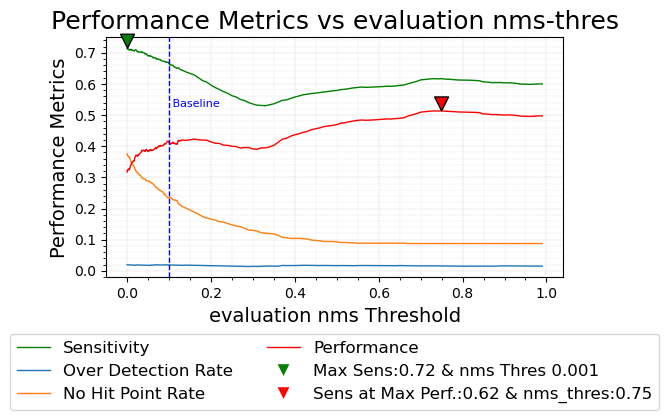

In [ ]:
# Evaluation: Non-Maximum Suppression Threshold
csv_file_path= "csv/ev_nms_thres.csv" 

#read the csv file:
df = pd.read_csv(csv_file_path)
df = df.sort_values(by='ev_nms_thres', ascending=True)
sens=df["sens"].astype(float)
ev_nms_thres=df["ev_nms_thres"].astype(float)
o_d_r=df["over_detecion_rate"].astype(float)
n_hp_r=df["no_hit_point_rate"].astype(float)
diff_sens_fp = sens - o_d_r - n_hp_r
diff_sens_fp = diff_sens_fp.apply(lambda x: x if x >= 0 else 0) # for having a better overview: negative differences are set to 0

print("the average of Over Detection Rate is: ", round(o_d_r.mean(), 4))
print("Amount of points made: ",len(ev_nms_thres))

#max arrows
# max sens
max_sens = sens.max()
max_sens_index = sens.idxmax()
max_sens_x = ev_nms_thres[max_sens_index]

# max diff 
max_diff_sens_fp = diff_sens_fp.max()
max_diff_index = diff_sens_fp.idxmax()
max_diff_x = ev_nms_thres[max_diff_index]
sens_at_max_diff = sens[max_diff_index]

plt.plot(ev_nms_thres, sens, linestyle='-', color='g', label='Sensitivity', markersize=8, linewidth=1)
plt.plot(ev_nms_thres, o_d_r, label='Over Detection Rate', linewidth=1)
plt.plot(ev_nms_thres, n_hp_r, label='No Hit Point Rate', linewidth=1)
plt.plot(ev_nms_thres, diff_sens_fp, linestyle='-', color='r', label='Performance', linewidth=1)

baseline_line = plt.axvline(x=0.1, color='b', linestyle='--', linewidth=1, label='_nolegend_')
plt.text(0.1, plt.ylim()[1] * 0.7, ' Baseline', color='b', fontsize=8, ha='left')

#plt.plot(ev_nms_thres, diff_sens_odr, linestyle='-', color='r', label='Performance Sensitivity - Over Detection Rate', markersize=8, linewidth=2)

plt.annotate(f'', 
            xy=(max_sens_x, max_sens ), 
            xytext=(max_sens_x, max_sens + 0.0000005),
            arrowprops=dict(facecolor='green', shrink=0.05, headwidth=10, headlength=10, width=2),
            ha='center', fontsize=10)

plt.annotate(f'', 
            xy=(max_diff_x, max_diff_sens_fp), 
            xytext=(max_diff_x, max_diff_sens_fp + 0.0001),
            arrowprops=dict(facecolor='red', shrink=0.05, headwidth=10, headlength=10, width=2),
            ha='center', fontsize=10)

dummy_point_diff = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label=f'Sens at Max Perf.:{sens_at_max_diff:.2f} & nms_thres:{round(max_diff_x, 4)}')
dummy_point = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='green', markersize=10, label=f'Max Sens:{max_sens:.2f} & nms Thres {max_sens_x}')
        
# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.minorticks_on()  # Enable minor ticks
plt.grid(True, which='minor', linestyle=':', linewidth=0.2)  # Add minor grid lines

# Add labels and title
plt.xlabel('evaluation nms Threshold', fontsize=14)
plt.ylabel('Performance Metrics', fontsize=14)
plt.title('Performance Metrics vs evaluation nms-thres', fontsize=18)

# Add a legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(dummy_point)
handles.append(dummy_point_diff)
plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=12, ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# plt.annotate(f'Max Sens: {max_sens:.2f}', 
#              xy=(max_sens_ev_nms_thres, max_sens), 
#              xytext=(max_sens_ev_nms_thres, max_sens + 0.05),
#              arrowprops=dict(facecolor='black', shrink=0.05),
#              ha='center', fontsize=10)
plt.savefig('../../graphen/ev_nms_thres.png',  dpi=400, bbox_inches='tight')
plt.show()

the average of Over Detection Rate is:  0.0227
Amount of points made:  115


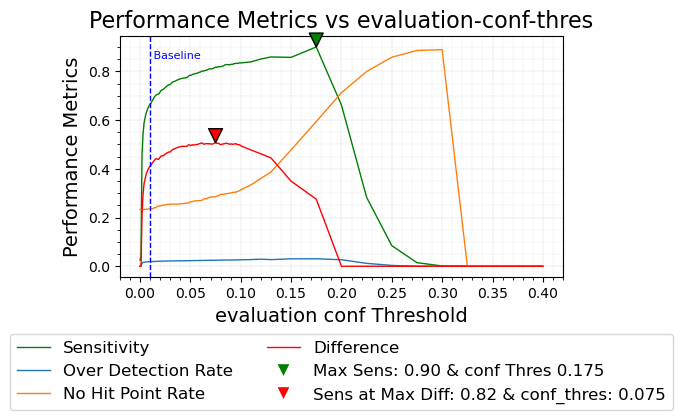

In [ ]:
# Evaluation: Confidence Threshold
csv_file_path = "ev_conf_thres_merged.csv"

# Read the csv file
df = pd.read_csv(csv_file_path)
df = df.sort_values(by='ev_conf_thres', ascending=True)
df = df[df['ev_conf_thres'] <= 0.4] #for having a better graph we will plot only 0 until 0.4

sens = df["sens"].astype(float)
ev_conf_thres = df["ev_conf_thres"].astype(float)
o_d_r = df["over_detecion_rate"].astype(float)
n_hp_r = df["no_hit_point_rate"].astype(float)
diff_sens_fp = sens - o_d_r - n_hp_r
diff_sens_fp = diff_sens_fp.apply(lambda x: x if x >= 0 else 0)  # for having a better overview: negative differences are set to 0

df_mean = df[df['ev_conf_thres'] <= 0.2] 
o_d_r_mean= df_mean["over_detecion_rate"]
print("the average of Over Detection Rate is: ", round(o_d_r_mean.mean(), 4))
print("Amount of points made: ",len(sens))

# max sens
max_sens = sens.max()
max_sens_index = sens.idxmax()
max_sens_x = ev_conf_thres[max_sens_index]

# max diff 
max_diff_sens_fp = diff_sens_fp.max()
max_diff_index = diff_sens_fp.idxmax()
max_diff_x = ev_conf_thres[max_diff_index]
sens_at_max_diff = sens[max_diff_index]

plt.plot(ev_conf_thres, sens, linestyle='-', color='g', label='Sensitivity', markersize=8, linewidth=1)
plt.plot(ev_conf_thres, o_d_r, label='Over Detection Rate', linewidth=1)
plt.plot(ev_conf_thres, n_hp_r, label='No Hit Point Rate', linewidth=1)
plt.plot(ev_conf_thres, diff_sens_fp, linestyle='-', color='r', label='Performance', linewidth=1)

baseline_line = plt.axvline(x=0.01, color='b', linestyle='--', linewidth=1, label='_nolegend_')
plt.text(0.01, plt.ylim()[1] * 0.9, ' Baseline', color='b', fontsize=8, ha='left')

# Annotate the maximum sensitivity point
plt.annotate(f'', 
             xy=(max_sens_x, max_sens), 
             xytext=(max_sens_x, max_sens + 0.0000005),
             arrowprops=dict(facecolor='green', shrink=0.05, headwidth=10, headlength=10, width=2),
             ha='center', fontsize=10)

# Annotate the maximum Performance point
plt.annotate(f'', 
             xy=(max_diff_x, max_diff_sens_fp), 
             xytext=(max_diff_x, max_diff_sens_fp + 0.0001),
             arrowprops=dict(facecolor='red', shrink=0.05, headwidth=10, headlength=10, width=2),
             ha='center', fontsize=10)

dummy_point_diff = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label=f'Sens at Max Diff: {sens_at_max_diff:.2f} & conf_thres: {round(max_diff_x, 4)}')
dummy_point = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='green', markersize=10, label=f'Max Sens: {max_sens:.2f} & conf Thres {max_sens_x}')

# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.minorticks_on()  # Enable minor ticks
plt.grid(True, which='minor', linestyle=':', linewidth=0.2)  # Add minor grid lines

# Add labels and title
plt.xlabel('evaluation conf Threshold', fontsize=14)
plt.ylabel('Performance Metrics', fontsize=14)
plt.title('Performance Metrics vs evaluation-conf-thres', fontsize=16)

# Add a legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(dummy_point)
handles.append(dummy_point_diff)
plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=12, ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('/mnt/c/Users/vinze/Dropbox/Universität/8.Bachelorarbeit/graphen/ev_conf_thres.png', dpi=400, bbox_inches='tight')
plt.show()

51 51 51 51


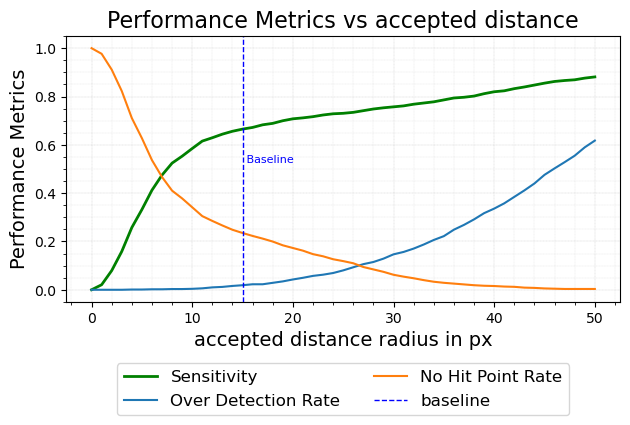

In [4]:
#accepted distance
csv_file_path= "csv/accepted_distance.csv" 

#read the csv file:
df = pd.read_csv(csv_file_path)
df = df.sort_values(by='accepted_dist', ascending=True)
sens=df["sens"].astype(float)
accepted_dist=df["accepted_dist"].astype(float)
o_d_r=df["over_detecion_rate"].astype(float)
n_hp_r=df["no_hit_point_rate"].astype(float)

## Annotate specific points
max_sens = sens.max()
max_sens_index = sens.idxmax()
#max_sens_ev_conf_thres = ev_conf_thres[max_sens_index]

print(len(accepted_dist), len(sens), len(o_d_r), len(n_hp_r))

plt.plot(accepted_dist, sens, linestyle='-', color='g', label='Sensitivity', markersize=8, linewidth=2)
plt.plot(accepted_dist, o_d_r, label='Over Detection Rate' )
plt.plot(accepted_dist, n_hp_r, label='No Hit Point Rate')

baseline_line = plt.axvline(x=15, color='b', linestyle='--', linewidth=1, label='baseline')
plt.text(15, plt.ylim()[1] * 0.5, ' Baseline', color='b', fontsize=8, ha='left')

#plt.annotate('', 
#             xy=(max_sens_ev_conf_thres, max_sens), 
#             xytext=(max_sens_ev_conf_thres, max_sens + 0.05),
#             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=10, headlength=10, width=2),
#             ha='center', fontsize=10)
#dummy_point = plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='black', markersize=10, label=f'Max Sens: {max_sens:.2f} at nms Thres {max_sens_ev_conf_thres}')
        
# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.minorticks_on()  # Enable minor ticks
plt.grid(True, which='minor', linestyle=':', linewidth=0.2)  # Add minor grid lines

# Add labels and title
plt.xlabel('accepted distance radius in px', fontsize=14)
plt.ylabel('Performance Metrics', fontsize=14)
plt.title('Performance Metrics vs accepted distance', fontsize=16)

# Add a legend with a better placement
handles, labels = plt.gca().get_legend_handles_labels()
if baseline_line not in handles:
    handles.append(baseline_line)

plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=12, ncol=2)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('../../graphen/accepted_distance.png',  dpi=400, bbox_inches='tight')
plt.show()
plt.close()